<a href="https://colab.research.google.com/github/DanyaFire/StatPrac/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Предсказание хитовости фильма**

**Цель проекта:** Основываясь на популярности и рейтинге фильма, определить, насколько высока вероятность того, что этот фильм станет хитом на века.

**Какие есть поля для работы в датасете:**

*   title - название фильма
*   overview - обзор
*   release_date - дата выпуска
*   popularity - популярность
*   vote_average - рейтинг
*   vote_count - количество голосов

*   **Определение "хита":**  Для определения порогового значения "хитовости" мы будем использовать комбинацию признаков.  Например, фильм может считаться хитом, если он отвечает следующим условиям:
    *   `popularity` выше определенного порога (например, медиана или 75-й процентиль по датасету).
    *   `vote_average` выше определенного порога (например, 7.0).
    *   `vote_count` выше определенного порога (например, 1000).

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Python_KDA/top_rated_movies(tmdb).csv')
df.head()

,id,title,overview,release_date,popularity,vote_average,vote_count
0,278,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,1994-09-23,5.522,8.708,27883
1,238,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",1972-03-14,5.317,8.689,21151
2,240,The Godfather Part II,In the continuing saga of the Corleone crime f...,1974-12-20,4.747,8.570,12771
3,424,Schindler's List,The true story of how businessman Oskar Schind...,1993-12-15,4.457,8.567,16219
4,1356039,Counterattack,When a hostage rescue mission creates a new en...,2025-02-27,9.430,8.524,431


Анализ отсутствующих строк:

In [ ]:
df.isna().sum()

,0
id,0
title,0
overview,0
release_date,2
popularity,0
vote_average,0
vote_count,0


Заметим, что в столбце "Дата релиза" имеются некорректные данные.
Выполним обработку данных.

In [ ]:
# Преобразуем столбец в datetime, некорректные значения преобразуем в NaT (Not a Time)
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Заполняем NaT самой ранней датой
earliest_date = df['release_date'].min()
df['release_date'] = df['release_date'].fillna(earliest_date)

# Преобразуем обратно в строку
df['release_date'] = df['release_date'].dt.strftime('%Y-%m-%d')

# Проверка, что NaN'ов больше нет
print("\nПропущенные значения после обработки:")
print(df.isnull().sum())


Пропущенные значения после обработки:
id              0
title           0
overview        0
release_date    0
popularity      0
vote_average    0
vote_count      0
dtype: int64


Построим гистограмму распределения рейтинга.

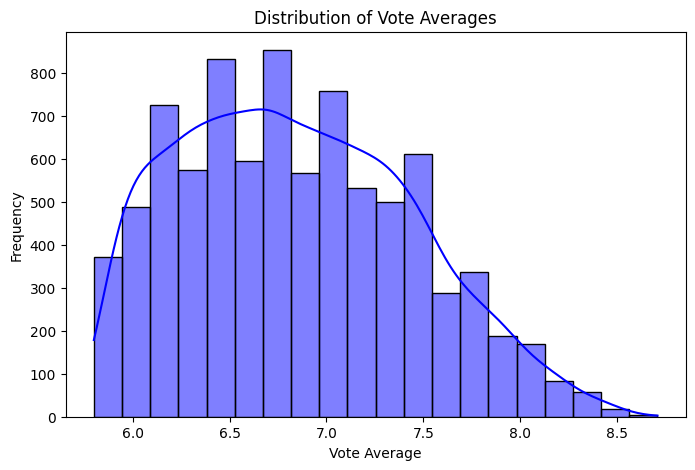

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['vote_average'], bins=20, kde=True, color='blue')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.title('Distribution of Vote Averages')
plt.show()

Построим гистограмму распределения популярности.

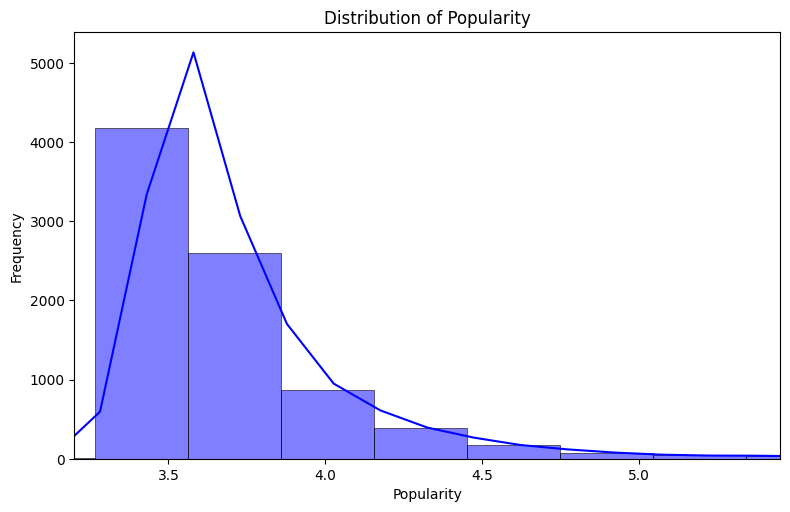

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['popularity'], bins=100, kde=True, color='blue')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.xlim(3.2,df['popularity'].quantile(0.99))
plt.tight_layout()
plt.title('Distribution of Popularity')
plt.show()

Посмотрим, какие фильмы из набора данных находятся на первых 10-ти местах по популярности.

<ipython-input-10-ed3b30b83001>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = top_movies['title'], x = top_movies['popularity'], palette='Reds_r')


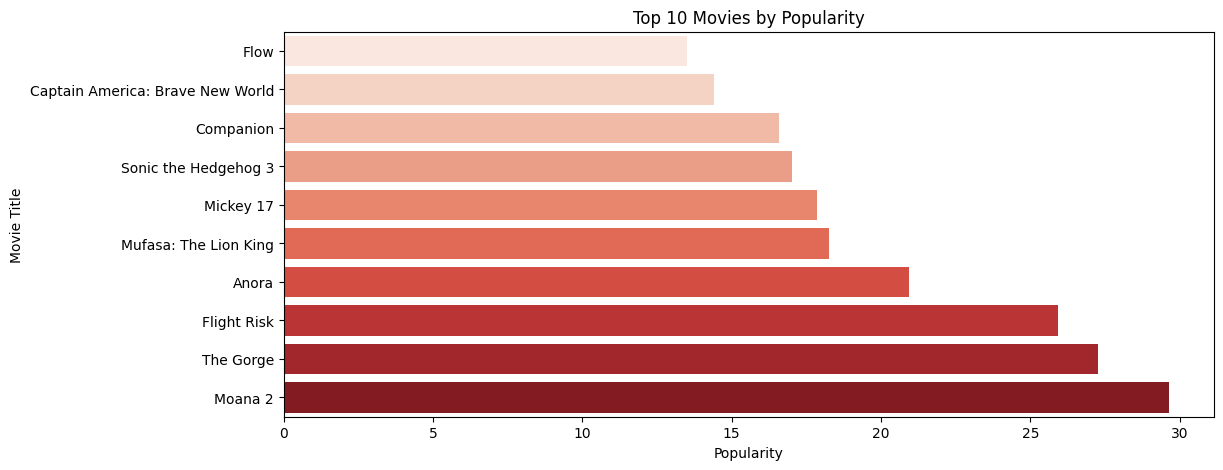

In [ ]:
top_movies = df.nlargest(10, 'popularity')
plt.figure(figsize=(12, 5))
sns.barplot(y = top_movies['title'], x = top_movies['popularity'], palette='Reds_r')
plt.xlabel('Popularity')
plt.ylabel('Movie Title')
plt.title('Top 10 Movies by Popularity')
plt.gca().invert_yaxis()
plt.show()

Посмотрим, какие фильмы из набора данных находятся на первых 10-ти местах по рейтингу.

<ipython-input-8-9c20ee89f3eb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_rated_movies['title'], x=top_rated_movies['vote_average'], palette='Oranges_r')


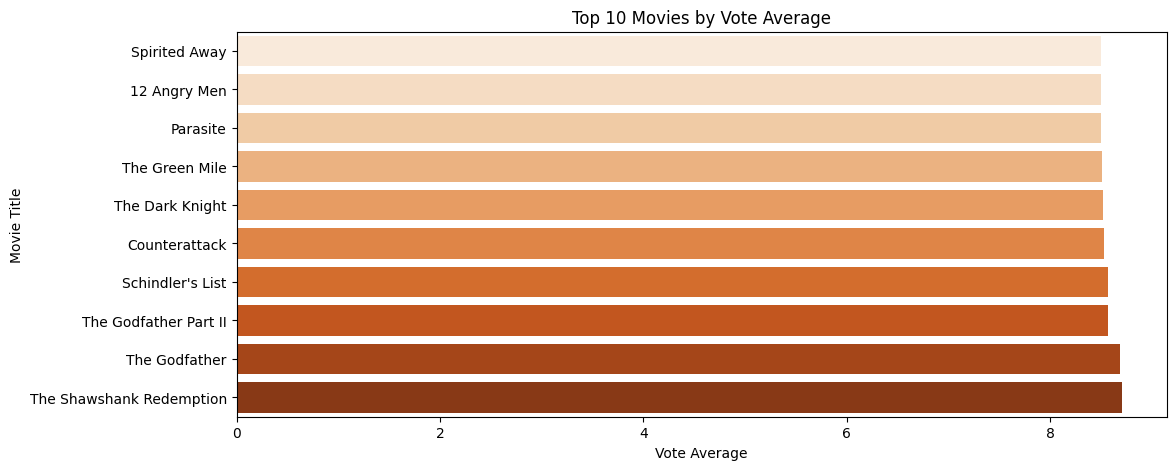

In [ ]:
top_rated_movies = df.nlargest(10, 'vote_average')
plt.figure(figsize=(12, 5))
sns.barplot(y=top_rated_movies['title'], x=top_rated_movies['vote_average'], palette='Oranges_r')
plt.xlabel('Vote Average')
plt.ylabel('Movie Title')
plt.title('Top 10 Movies by Vote Average')
plt.gca().invert_yaxis()
plt.show()

Теперь посмотрим, как связаны между собой популярность и рейтинг:
P.S. По графику видно некоторые выбросы, поэтому стало интересно, нет ли здесь обмана. Выведем явные значения этих выбросов и увидим, что они действительно есть в датасете.

                                 title  popularity  vote_average
68                                Flow      13.517         8.300
648                          The Gorge      27.269         7.773
780               Sonic the Hedgehog 3      17.029         7.700
1425             Mufasa: The Lion King      18.250         7.474
2635                           Moana 2      29.661         7.162
3060                             Anora      20.921         7.065
3138                         Companion      16.594         7.100
3343                         Mickey 17      17.870         7.015
7274  Captain America: Brave New World      14.420         6.174
7615                       Flight Risk      25.919         6.121


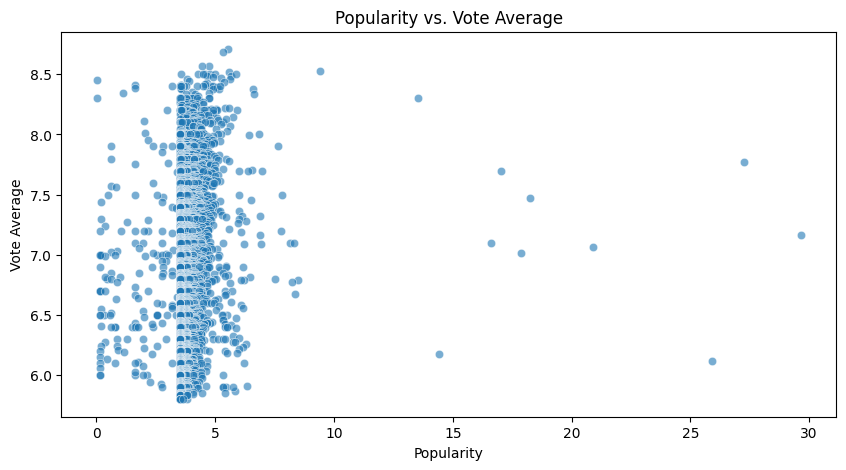

In [ ]:
print(df[df['popularity'] > 10][['title', 'popularity', 'vote_average']])
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['popularity'], y=df['vote_average'], alpha=0.6)
plt.xlabel('Popularity')
plt.ylabel('Vote Average')
plt.title('Popularity vs. Vote Average')
plt.show()

Интересно узнать, сколько фильмов в каждый год из списка выходило. Выведем график зависимости количества фильмов от года.

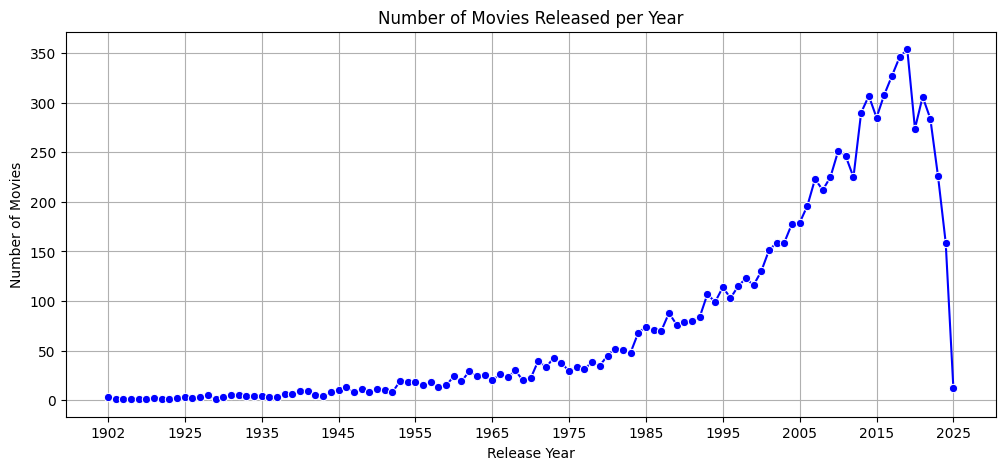

In [ ]:
df['release_year'] = df['release_date'].str[:4]

year_counts = df['release_year'].value_counts().sort_index()
plt.figure(figsize=(12, 5))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o', color='blue')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies Released per Year')
plt.xticks(year_counts.index[::10])
plt.grid(True)
plt.show()

Построим корреляционную матрицу

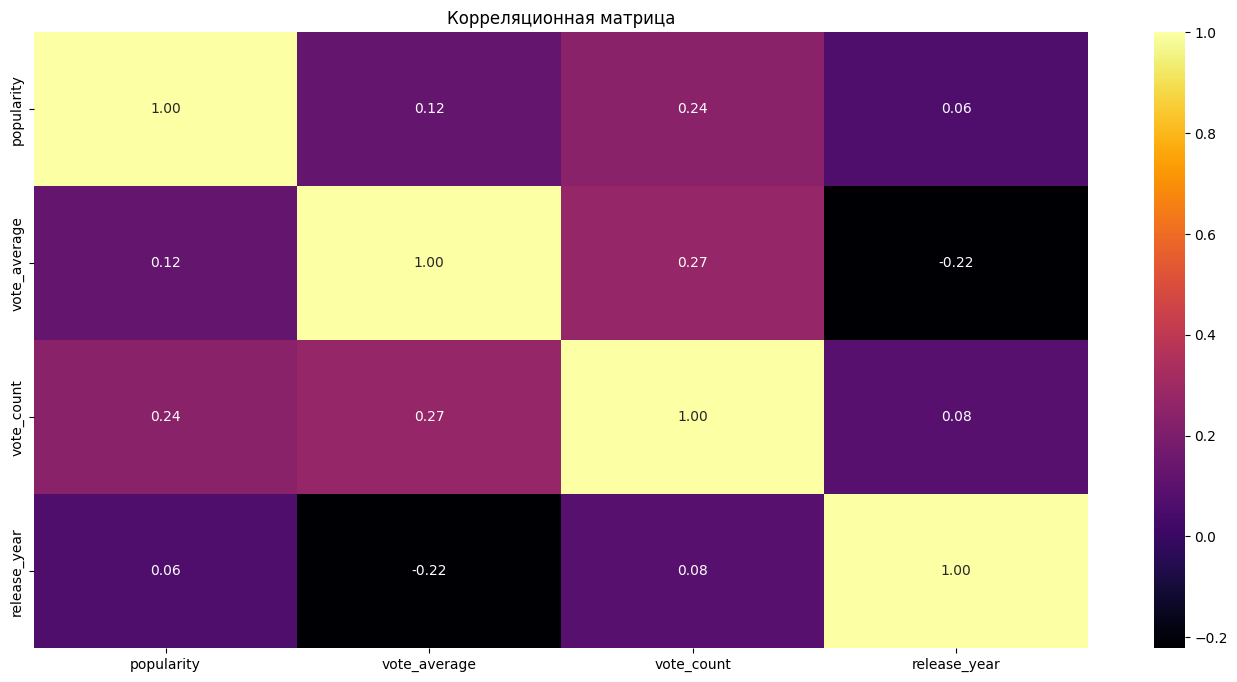

In [ ]:
# Преобразуйте в числовой тип (int), если это возможно
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')

# Числовые признаки, которые мы будем анализировать
numeric_features = ['popularity', 'vote_average', 'vote_count', 'release_year']

# Корреляционная матрица
corr_matrix = df[numeric_features].corr()
plt.figure(figsize=(17, 8)) # Немного уменьшил размер, чтобы лучше помещалась на экран
sns.heatmap(corr_matrix, annot=True, cmap="inferno", fmt=".2f")
plt.title("Корреляционная матрица")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

#*Прогнозное моделирование*

На этом этапе мы также проведём бинарную классификацию популярности фильмов с использованием трёх моделей машинного обучения: модель логистической регрессии, модели случайного леса и метода опорных векторов (SVM).

1. Подготовка целевой переменной (Target)
* Сначала вычислим медиану столбца vote_count (количество голосов), относительно которой будем считать, популярен фильм или же нет.

* Создаём бинарный таргет is_popular, где:
  **1** означает, что фильм популярный (количество голосов выше медианы),
  **0** означает, что фильм непопулярный

In [ ]:
median_vote_count = df['vote_count'].median()
df['is_popular'] = (df['vote_count'] > median_vote_count).astype(int)

2. Подготовка признаков (Features)
* Выбираются три признака для предсказания: популярность, средняя оценка и год выпуска

* Пропущенные значения заполняются нулями

* X - матрица признаков, y - целевая переменная

In [ ]:
features = ['popularity', 'vote_average', 'release_year']
X = df[features].fillna(0)
y = df['is_popular']

3. Разделение данных
* Данные разделяются на обучающую (80%) и тестовую (20%) выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

4. Масштабирование признаков
* Признаки нормируются (приводятся к нулевому среднему и единичной дисперсии)

* используется fit_transform для обучающих данных, transform для тестовых (чтобы избежать утечки данных)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

5. Определение моделей
Создается словарь с тремя разными моделями классификации:

  1. Логистическая регрессия

  2. Случайный лес (100 деревьев)

  3. Метод опорных векторов (SVM)

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

6. Построение графика, на котором можно наблюдать классификацию с помощью логистической регрессии. Были выбраны два признака из трёх, которые всю работу сравниваются друг с другом: popularity и vote_average.
**Что показывает график?**
* Синие точки — фильмы, которые модель предсказывает как "непопулярные" (is_popular = 0).

* Красные точки — фильмы, предсказанные как "популярные" (is_popular = 1).

* Градиентный фон показывает вероятность отнесения к классу "1". Чем краснее область, тем выше уверенность модели в популярности.

* Граница решения — это линия, где вероятность равна 0.5 (модель не уверена).

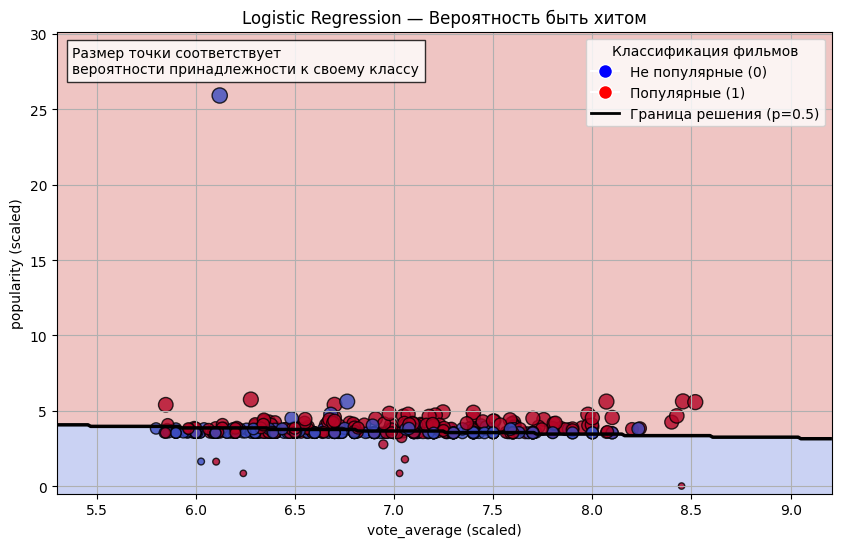

In [ ]:
# 1. Предобработка
features = ['vote_average', 'popularity']
X = df[features].values
y = df['is_popular'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Обучение модели
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# 3. Выбор 100 случайных точек
np.random.seed(42)
indices = np.random.choice(len(X), size = 500, replace=False)
X_sample = X[indices]
y_sample = y[indices]
probas = model.predict_proba(X_sample)[:, 1]  # вероятность "хита"

# 4. Граница принятия решений
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(grid).reshape(xx.shape)

# 5. Визуализация
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2.5)

# Отображение точек: цвет — факт, размер — вероятность
plt.scatter(
    X_sample[:, 0], X_sample[:, 1],
    c=y_sample,  # фактические классы: 0/1
    cmap='coolwarm',
    edgecolor='k',
    s=100 * probas + 20,  # размер зависит от вероятности
    alpha=0.8,
)

# Создаем кастомную легенду
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Не популярные (0)',
              markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Популярные (1)',
              markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], color='black', lw=2, label='Граница решения (p=0.5)')
]

plt.legend(handles=legend_elements, title="Классификация фильмов", loc='upper right')

# Добавляем информацию о размере точек
plt.text(0.02, 0.91, "Размер точки соответствует\nвероятности принадлежности к своему классу",
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel('vote_average')
plt.ylabel('popularity')
plt.title('Logistic Regression — Вероятность быть хитом')
plt.grid(True)
plt.show()

7.  Обучение и оценка моделей
Для каждой модели выполняется:

  a) Обучение на тренировочных данных;

  b) Предсказания на тестовых данных;

  c) Вычисление accuracy (доли правильных ответов)

  d) Построение и отображение матрицы ошибок (confusion matrix)

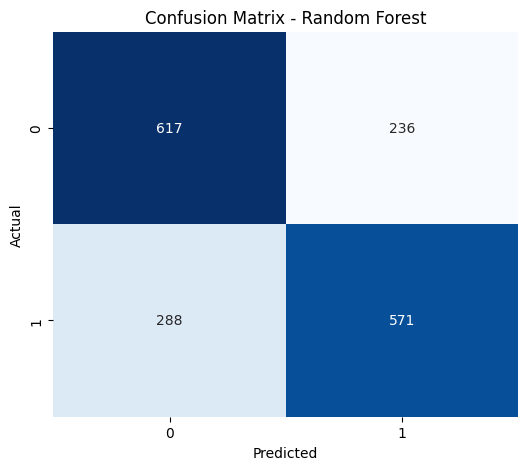

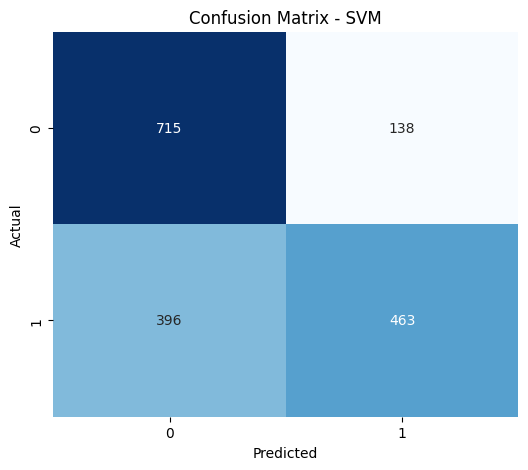

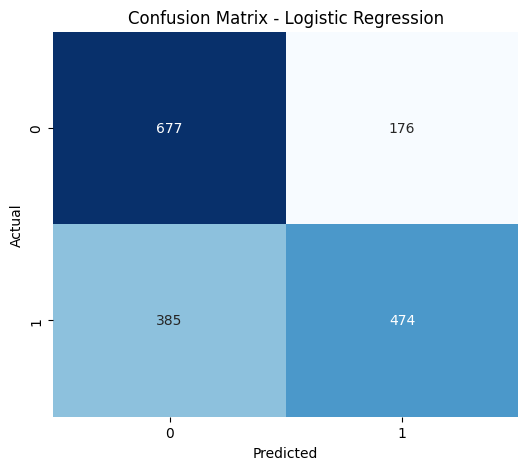

Random Forest: Accuracy = 0.69
SVM: Accuracy = 0.69
Logistic Regression: Accuracy = 0.67


In [ ]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # Обучение модели
    y_pred = model.predict(X_test)  # Предсказание на тестовых данных
    accuracy = accuracy_score(y_test, y_pred)  # Вычисление точности
    results[name] = accuracy  # Сохранение результата

    # Визуализация матрицы ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

for name, acc in results.items():
    print(f'{name}: Accuracy = {acc:.2f}')